# DPCM experiments

Assuming we have a slowly changing signal of some sort which may be subject to occasional events causing some oscillation, like for example from a motion sensor. If we wanted to log these values, we would end up with lots of data where actually nothing much happened. We could then decide to store or transmit only changes in the signal, like the difference from sample `n` to sample `n-1`, which is referred to as `delta_n`. To reconstruct these values, we'd add each delta to the previously reconstructed value, starting out with an initial DC offset.

But there could be better: If we already know some more characteristics of the signal, such as slow changes most of the time, we could try a prediction based upon the signal history and only transmit the **deviation** from this prediction.
If Sender and Receiver are aware of such a deterministic prediction, the signal can be reconstructed without loss.

This is in general referred to as DPCM -- **Differential Pulse Code Modulation**

If the signal has no rapid changes, we end up with small delta values which can be encoded with less bit depth per value.
Plus, we can apply quantization tricks on the delta signal to save even more bits using extended compression methods in order to support lossy compression.

In [1]:
import sys
sys.path.insert(0, "../../")

In [2]:
!pip install matplotlib >/dev/null

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Prediction function

For a generic signal that shows mostly piecewise linear characteristics in most cases, we define a prediction function as follows, based upon the last two samples:

In [4]:
def predict_linear(v1, v0):
    return v0 + (v0 - v1)

Let's test this function using a simple signal generator.

In [5]:
import math

def gen_data(n, phase):
    a = np.zeros((n))
    k0 = 2
    k1 = 5
    k2 = 8
    k3 = 9
    f = 4 * math.pi + phase
    for i in range(n):
        a[i] = 20 * math.sin(i * k0 * f / n) - 10.0
        a[i] += 7 * math.sin(i * k1 * f / n)
        a[i] += 5 * math.sin(i * k2 * f / n)
        a[i] += 2 * math.sin(i * k3 * f / n)
        
    return a

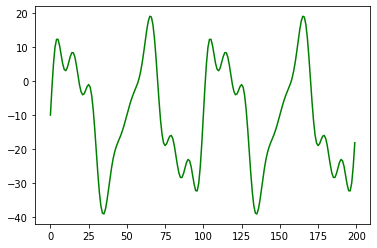

In [6]:
a = gen_data(200, 0.0)
plt.plot(a, 'g', label = 'original')

Note that we applied some DC offset to the function such that it has a value -10.0 at x = 0.

In [7]:
def run_predictor(a):
    #start condition:
    z = []
    z = [a[0], a[1]]
    v1, v0 = a[0], a[1]

    for v in a[2:]:
        zn = predict_linear(v1, v0)
        d = v - zn
        z.append(d)
        v1, v0 = v0, v

    return z


Let's run the prediction and observe the value range (we've omitted the first two start values):

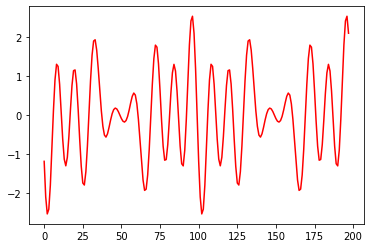

In [8]:
z = run_predictor(a)
plt.plot(z[2:], 'r', label = 'encoded')

### Reconstruction

Reconstructing the signal is again rather trivial. We grab the first initial values from the array, then we do the prediction, plus add the delta deviation to retrieve the original. The routine effectively uses only one inverse operation.

In [9]:
def run_reconstruction(a):
    #start condition:
    z = []
    z = [a[0], a[1]]
    v1, v0 = a[0], a[1]

    for d in a[2:]:
        zn = predict_linear(v1, v0)
        v = zn + d
        z.append(v)
        v1, v0 = v0, v

    return z

To show the maximum floating point errors between original and reconstructed signal:

In [10]:
ar = run_reconstruction(z)
diff = [ ia - ar[i] for i, ia in enumerate(a) ]
min(diff), max(diff)

(0.0, 0.0)

### Error propagation

The problem with an analog DPCM reconstruction: due to rounding errors, the reconstructed signal will deviate from the original over time. Let's add an error to the DC start values of the encoded signal:

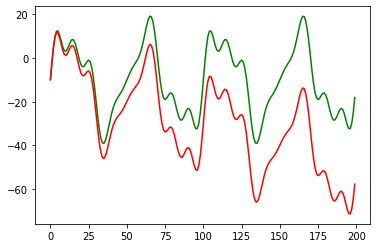

In [11]:
z[0] += 0.1
z[1] -= 0.1
ar = run_reconstruction(z)
plt.plot(a, 'g', label = 'reconstructed_error')
plt.plot(ar, 'r', label = 'reconstructed_error')

These errors are a property of floating point arithmetics: the machine epsilon error comes into play, therefore a float signal is never fully reconstructible, also used is the term 'irreversible'. In the digital reality however, our signal values are constrained, therefore we don't operate with floating point but rather raw bit vectors or fixed point/integer arithmetics.

Before we move on to raw hardware representation, let's do a short excursion into quantization.

## Quantizing float values

Let's introduce a quantization function taking float values and converting them such that they can only take discrete values, for approximation of a given function.

In [12]:
def dz_quant_forward(x, w, delta):
    return int(np.sign(x) * (max(0, np.floor((abs(x) - 0.5 * w) / delta + 1))))

def dz_quant_inverse(k, w, delta):
    return np.sign(k) * (delta * (abs(k) - 1 + 0.5) + 0.5 * w)

In [13]:
a = list(map(lambda x: -8.0 + 0.1 * x, range(200)))
q = 4.0
b = list(map(lambda x : dz_quant_forward(x, q, q), a))
c = list(map(lambda x : dz_quant_inverse(x, q, q), b))

### Quantization plot

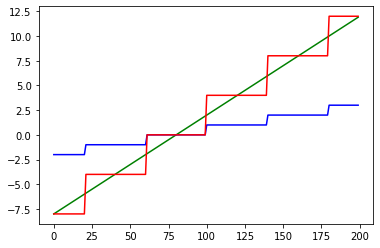

In [14]:
plt.plot(a, 'g', label = 'original')
plt.plot(b, 'b', label = 'forward')
plt.plot(c, 'r', label = 'inverse')

In the signal processing world, this discretization of a real analog signal is in fact done by the analog to digital conversion, for example, a range of -1 V to 1 Vpp is mapped onto the value range [-2048, 2047] (using 12 bits).

In this case, the source signal is quantized. Once represented by integers, it can be prediction-coded and reconstructed fully without loss.

## Hardware implementation

For the hardware implementation, we use rather integers than floats. Because we are dealing with bit vectors in hardware, we use the myHDL-builtin `intbv` type. We leave the effective bit width open for simplicity.

In [15]:
from myirl.emulation.myhdl import *
a = [ intbv(n) for n in range(-20, 100) ]

To make quantization simpler and avoid division, we reduce to bit truncation only for the quantization function. We add a bit of rounding:

In [16]:
def fp_quant_forward(x, dpower):
    r = 2**(dpower-1)-1
    return intbv(x + r)[:dpower]

def fp_quant_inverse(x, dpower):
    return x << dpower

In [17]:
DPOWER = 4
b = map(lambda x: fp_quant_forward(x, DPOWER), a)
t = list(b)
c = map(lambda x: int(fp_quant_inverse(x, DPOWER)), t)

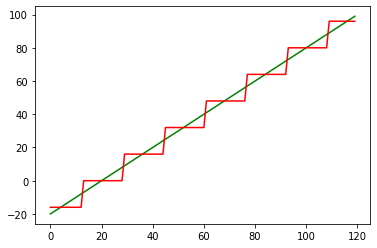

In [18]:
plt.plot(list(map(lambda x: int(x), a)), 'g', label = 'original')
plt.plot(list(map(lambda x: int(x), c)), 'r', label = 'quantized')

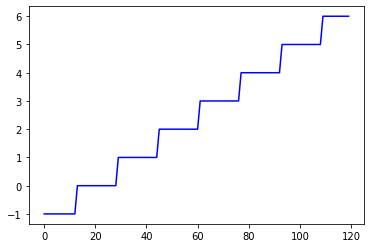

In [19]:
plt.plot(list(map(lambda x: int(x), t)), 'b', label = 'truncated')

We now build a piece of hardware, that operates on a value sequence. This sequence is clocked into a data port of the hardware unit.

## Pipelining

**TODO**: Explain `@pipeline` and bit arithmetics

In [20]:
from mypipe import pipeline
from myirl import Comment, block as myirl_block

### DPCM encoder pipeline

The pipeline generator takes an `en` signal which is passed through every stage of the pipeline, and is fed back to `valid` which is signaling that valid data is output from the pipe.
First, we need to take care of the start condition, which buffers the first two values in a queue (`buf[0]` and `buf[1]`. The newest data is fed into `buf[1]`. Once two values have been acquired, the prediction stage is enabled. The following stage takes the following buffered input data `buf[1]` and subtracts the predicted value in order to retrieve the transmitted error signal.

In [21]:
Bool = Signal.Type(bool)

@myirl_block
def dpcm(clk : ClkSignal,
         reset : ResetSignal,
         en  : Bool,
         idata : Signal,
         odata : Signal.Output,
         valid : Bool.Output
    ):
    
    # Create a value buffer for the first two plus two workers;
    buf = [ idata.clone("buf%d" % i) for i in range(2) ]
    N = idata.size()
    
    v, o = [ Signal(intbv(min=-2**N, max=2**N)) for n in "vo" ]
    
    @pipeline(clk, reset, en, None, valid)
    def encode(ctx):
        If = ctx.If

        # First two are DC data, then comes the AC sequence:
        # D0    D1    A2    A3 ...
        
        yield [ buf[1].set(idata) ]

        yield [ buf[0].set(buf[1]) ]

        yield [
            Comment("Prediction stage"),
            v.set(predict_linear(buf[0], buf[1])),
        ]

        yield [
            Comment("Error signal subtraction stage"),
            o.set(buf[1] - v) # Buffered idata minus predicted
        ]
        
    wirings = [
        odata.wireup(o[N:])
    ]
        
    return locals()
         

Let's create a test bench class, passing a few values:

In [22]:
from myirl.emulation.myhdl import *
from myirl.test.common_test import run_ghdl, gen_osc
from myirl.kernel import components
import wavedraw
import nbwavedrom

@factory
class Testbench(components.DesignModule):
    
    def __init__(self, dpcm_implementation):
        self.dpcm_impl = dpcm_implementation
        super().__init__("tb_design")

    @block_component
    def testbench_dpcm(self, values):
        clk = ClkSignal(name = 'clk')
        src, dst = [ Signal(intbv(min=-2**11, max = 2*11)) for _ in range(2) ]
        en, dval = [ Bool() for _ in range(2) ]
        reset = ResetSignal(0, 1)

        osc = gen_osc(clk, 2)

        uut = self.dpcm_impl(clk = clk, reset = reset, en = en, idata = src, odata = dst, valid = dval)

        @instance
        def stim():
            reset.next = True
            en.next = False
            yield clk.posedge, clk.posedge
            reset.next = False
            yield clk.posedge
            en.next = True
            for v in self.values:
                src.next = v
                yield clk.posedge

            raise StopSimulation

        return instances()
    
    def run(self, values):
      
        self.values = list(map(lambda x: int(x), values))

        tb = self.testbench_dpcm(self.dpcm_impl)
        f = tb.elab(targets.VHDL, elab_all = True)
        run_ghdl(f, tb, debug = False, vcdfile= tb.name + ".vcd")
        return tb

In [23]:
def test(dpcm):
    values = gen_data(20, 0.0)
    td = Testbench(dpcm)
    tb = td.run(values)
    return td, tb
    
td, tb = test(dpcm)

 Declare obj 'testbench_dpcm' in context 'tb_design' 
Creating sequential 'testbench_dpcm/stim' 
DEBUG Skip latency accounting for `buf1`
DEBUG Skip latency accounting for `buf0`
DEBUG Skip latency accounting for `v`


/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/library/pipeline.py:147: TranslationWarning: encode(): `ce` (type <class 'myirl.kernel.sig.Alias'>) is not a pipeline signal
  base.warn("%s(): `ce` (type %s) is not a pipeline signal" % (func.__name__, type(ce)))
/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/library/pipeline.py:177: TranslationWarning: /tmp/ipykernel_8188/2734428269.py::dpcm:19: `idata` (type <class 'myirl.library.shift.SAlias'>) is not a pipeline signal
  base.warn("%s: `%s` (type %s) is not a pipeline signal" % (self.trace_info(), n, type(src)))
/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/library/pipeline.py:177: TranslationWarning: /tmp/ipykernel_8188/2734428269.py::dpcm:19: `buf1` (type <class 'myirl.emulation.signals.Signal'>) is not a pipeline signal
  base.warn("%s: `%s` (type %s) is not a pipeline signal" % (self.trace_info(), n, type(src)))
/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/library/pipeline.py:177: Translat

DEBUG Skip latency accounting for `o`


/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/kernel/components.py:221: UserWarning: Output valid of unit 'dpcm' not driven
  base.warnings.warn("Output %s of unit '%s' not driven" % \


 Writing 'dpcm' to file /tmp/myirl_tb_design_t8u17xeh/dpcm.vhdl 
 Writing 'testbench_dpcm' to file /tmp/myirl_tb_design_t8u17xeh/testbench_dpcm.vhdl 
 Creating library file /tmp/myirl_module_defs_9k67kz88/module_defs.vhdl 


## Wave trace

First, an auxiliary to display and configure the signal.

In [24]:
def waveform(tb, siglist = None, instname = 'dpcm'):

    _I = tb.name + '.' + "inst_%s_0." % (instname)

    if siglist is not None:
        cfg = {}
        for s in siglist:
            cfg[_I + s] = None
    else:
        cfg = siglist

    waveform = wavedraw.vcd2wave(tb.name + ".vcd", tb.name + '.clk', cfg, delta = 1)

    return waveform

The result of the pipeline is displayed below. The output signal is valid four cycles after the input is enabled.

In [25]:
sigs = [
    'en',
    'idata[11:0]',
    'en',
    'odata[11:0]',
    'valid',
    'buf1[11:0]',
    'buf0[11:0]',
]
nbwavedrom.draw(waveform(tb, sigs))

{'nets': [{'type': 'reg', 'name': 'dval', 'size': '1', 'hier': 'testbench_dpcm'}]}
{'nets': [{'type': 'reg', 'name': 'valid', 'size': '1', 'hier': 'testbench_dpcm.inst_dpcm_0'}]}
testbench_dpcm.inst_dpcm_0.en
testbench_dpcm.inst_dpcm_0.idata[11:0]
testbench_dpcm.inst_dpcm_0.odata[11:0]
testbench_dpcm.inst_dpcm_0.valid
testbench_dpcm.inst_dpcm_0.buf1[11:0]
testbench_dpcm.inst_dpcm_0.buf0[11:0]


Exercise questions (double click on this cell to see the solutions/hints)

1. The pipeline now has a depth of four, i.e. valid output appears after four cycles. How can we reduce it to less?
```{toggle} Hint: Eliminate buffering of idata and odata.
```
2. Why is this solution not too beautiful for stream reconstruction from the error data?
Double click to see the answer:
```{toggle} We are actually missing the two first DC values for reconstruction.
```

Two ways to fix this:
* We always assume initial DC values of 0
* We alter the pipeline process to emit the DC values for the first two cycles

Let's examine the second solution


### DPCM version two

To include the DC values, we need some multiplexing, meaning: The output will have to depend on the start condition.
For this, we move the output result assignment to an earlier pipeline stage (see `###`) and call the `get_ce()` method to check the delayed clock enable signal for the start condition. Since the `o` result does not require buffering up to the end of the pipeline as there is only one stage left, we can assign it directly to `odata` in the last stage.

This way, the pipeline ends up quite compressed, however the concurrency in the parallel processes is harder to read.

In [26]:
@myirl_block
def dpcm2(clk : ClkSignal,
         reset : ResetSignal,
         en  : Bool,
         idata : Signal,
         odata : Signal.Output,
         valid : Bool.Output
    ):
    
    buf = [ idata.clone("buf%d" % i) for i in range(2) ]
    
    N = idata.size()
    v, o = [ Signal(intbv(min=-2**N, max=2**N)) for n in "vo" ]

    @pipeline(clk, reset, en, None, valid)
    def encode(ctx):
        If = ctx.If
        
        yield [
            buf[1].set(idata)
        ]
        
        yield [
            If(encode.get_ce(2+1) == False).Then(
                o.set(buf[1]) ### buf[0] ready
            ).Else(
                o.set(buf[1] - v)
            ),
            buf[0].set(buf[1])
        ]
        
        yield [
            v.set(predict_linear(buf[0], buf[1])),
            odata.set(o[12:])
        ]

    return locals()


In [27]:
td2, tb2 = test(dpcm2)

 Declare obj 'testbench_dpcm' in context 'tb_design' 
Creating sequential 'testbench_dpcm/stim' 
DEBUG Skip latency accounting for `buf1`


/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/library/pipeline.py:147: TranslationWarning: encode(): `ce` (type <class 'myirl.kernel.sig.Alias'>) is not a pipeline signal
  base.warn("%s(): `ce` (type %s) is not a pipeline signal" % (func.__name__, type(ce)))
/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/library/pipeline.py:177: TranslationWarning: /tmp/ipykernel_8188/3638571011.py::dpcm2:16: `idata` (type <class 'myirl.library.shift.SAlias'>) is not a pipeline signal
  base.warn("%s: `%s` (type %s) is not a pipeline signal" % (self.trace_info(), n, type(src)))
/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/library/pipeline.py:177: TranslationWarning: /tmp/ipykernel_8188/3638571011.py::dpcm2:16: `buf1` (type <class 'myirl.emulation.signals.Signal'>) is not a pipeline signal
  base.warn("%s: `%s` (type %s) is not a pipeline signal" % (self.trace_info(), n, type(src)))
/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/library/pipeline.py:177: Transl

DEBUG Skip latency accounting for `o`
DEBUG Skip latency accounting for `buf0`
DEBUG Skip latency accounting for `v`
DEBUG Skip latency accounting for `odata`


/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/library/pipeline.py:177: TranslationWarning: /tmp/ipykernel_8188/3638571011.py::dpcm2:16: `buf0` (type <class 'myirl.emulation.signals.Signal'>) is not a pipeline signal
  base.warn("%s: `%s` (type %s) is not a pipeline signal" % (self.trace_info(), n, type(src)))
/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/library/pipeline.py:177: TranslationWarning: /tmp/ipykernel_8188/3638571011.py::dpcm2:16: `o` (type <class 'myirl.emulation.signals.Signal'>) is not a pipeline signal
  base.warn("%s: `%s` (type %s) is not a pipeline signal" % (self.trace_info(), n, type(src)))
/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/kernel/components.py:221: UserWarning: Output valid of unit 'dpcm2' not driven
  base.warnings.warn("Output %s of unit '%s' not driven" % \


 Writing 'dpcm2' to file /tmp/myirl_tb_design_vn84zkmc/dpcm2.vhdl 


AttributeError: ('/home/testing/src/myhdl2/myhdl.v2we/examples/../../myirl/library/pipeline.py::__init__:118# Pipeline function encode_stage1 #', '/tmp/ipykernel_8188/3638571011.py::encode:26', "'MyPipeline' object has no attribute 'bubble'")

In [28]:
nbwavedrom.draw(waveform(tb2, sigs, instname = "dpcm2"))

NameError: name 'tb2' is not defined

## Reconstruction (Hardware)

The inverse operation (i.e. reconstruction from the error signal) has a catch. Let's examine the software based reconstruction approach again:

In [29]:
def run_reconstruction(a):
    #start condition:
    z = []
    z = [a[0], a[1]]
    v1, v0 = a[0], a[1]

    for d in a[2:]:
        zn = predict_linear(v1, v0)
        v = zn + d ###
        z.append(v)
        v1, v0 = v0, v

    return z

Because we are running our prediction on a reconstructed value `v`, once we start repeating the loop, we can not run a pipe for continuous throughput, unlike the encoding process.
We have to wait until the reconstructed next value is available (see `###`) before we can feed it back into the predictor.

And: There is no trick. We simply can not predict the future. The only thing we could try, is multiplexing several inputs to the pipeline to keep it busy. However, there is another catch: for a single channel, the start condition is occuring in the beginning only. So the way out could be:

We cut the stream into frames, each beginning with the 'DC' header `a[0], a[1]`, buffer one or a few of them in memory and then process them interleaved in parallel
